In [1]:
import sunpy.map
import scipy.ndimage
import numpy as np
import sys
import math
import argparse
from skimage.measure import block_reduce

radsindeg = np.pi/180.
munaught  = 0.0000012566370614

In [2]:
import matplotlib.pyplot as plt

$$
B_x = B_p
$$

$$
B_y = -B_t
$$

$$
B_z = B_r
$$

In [3]:
# FITS file containing Bz-component of magnetic field vector
# FITS file containing By-component of magnetic field vector
# FITS file containing Bx-component of magnetic field vector
file_bz = 'files/hmi.sharp_cea_720s.377.20110215_020000_TAI.Br.fits'
file_by = 'files/hmi.sharp_cea_720s.377.20110215_020000_TAI.Bt.fits'
file_bx = 'files/hmi.sharp_cea_720s.377.20110215_020000_TAI.Bp.fits'

# FITS file containing error in Bz-component of magnetic field vector
# FITS file containing error in By-component of magnetic field vector
# FITS file containing error in Bx-component of magnetic field vector
file_bz_err = 'files/hmi.sharp_cea_720s.377.20110215_020000_TAI.Br_err.fits'
file_by_err = 'files/hmi.sharp_cea_720s.377.20110215_020000_TAI.Bt_err.fits'
file_bx_err = 'files/hmi.sharp_cea_720s.377.20110215_020000_TAI.Bp_err.fits'

# FITS file with bits identifying high-confidence in disambiguation result
file_conf_disambig = 'files/hmi.sharp_cea_720s.377.20110215_020000_TAI.conf_disambig.fits'

# FITS file with bits identifying the active region
file_bitmap = 'files/hmi.sharp_cea_720s.377.20110215_020000_TAI.bitmap.fits'

# FITS file containing line-of-sight component of magnetic field
file_los = 'files/hmi.sharp_cea_720s.377.20110215_020000_TAI.magnetogram.fits'

In [4]:
bz_map = sunpy.map.Map(file_bz)
by_map = sunpy.map.Map(file_by)
bx_map = sunpy.map.Map(file_bx)

bz_err_map = sunpy.map.Map(file_bz_err)
by_err_map = sunpy.map.Map(file_by_err)
bx_err_map = sunpy.map.Map(file_bx_err)

conf_disambig_map = sunpy.map.Map(file_conf_disambig)
bitmap_map = sunpy.map.Map(file_bitmap)
los_map = sunpy.map.Map(file_los)

See https://docs.sunpy.org/en/stable/code_ref/map.html#fixing-map-metadata for how to fix metadata before loading it with sunpy.map.Map.
See https://fits.gsfc.nasa.gov/fits_standard.html for the FITS unit standards. [sunpy.map.mapbase]


In [5]:
# get array data
bz                = bz_map.data
by                = by_map.data
bx                = bx_map.data
bz_err            = bz_err_map.data
by_err            = by_err_map.data
bx_err            = bx_err_map.data
conf_disambig     = conf_disambig_map.data
bitmap            = bitmap_map.data
los               = los_map.data

In [6]:
print("bz.shape = ", bz.shape)
print("by.shape = ", by.shape)
print("bx.shape = ", bx.shape)
print("bz_err.shape = ", bz_err.shape)
print("by_err.shape = ", by_err.shape)
print("bx_err.shape = ", bx_err.shape)
print("conf_disambig.shape = ", conf_disambig.shape)
print("bitmap.shape = ", bitmap.shape)
print("los.shape = ", los.shape)

bz.shape =  (377, 744)
by.shape =  (377, 744)
bx.shape =  (377, 744)
bz_err.shape =  (377, 744)
by_err.shape =  (377, 744)
bx_err.shape =  (377, 744)
conf_disambig.shape =  (377, 744)
bitmap.shape =  (377, 744)
los.shape =  (377, 744)


In [7]:
# get metadata
header = bz_map.meta

# get fits header key information
rsun_ref = header['rsun_ref']
dsun_obs = header['dsun_obs']
rsun_obs = header['rsun_obs']
cdelt1   = header['cdelt1']

In [8]:
print("Patch center w.r.t. patch lower-left")
print(f"CRPIX1 = {header['CRPIX1']} pixel")
print(f"CRPIX2 = {header['CRPIX2']} pixel")
print()
print("Patch center coords in Carrington lon. lat.")
print(f"CRVAL1 (lon) = {header['CRVAL1']} degree")
print(f"CRVAL2 (lat) = {header['CRVAL2']} degree")
print()
print("Angular size of pixel at Sun's center [degree]")
print(f"CDELT1 = {header['CDELT1']} degree")
print(f"CDELT2 = {header['CDELT2']} degree")
print()
print("1 AU [m]")
print(f"DSUN_REF = {header['DSUN_REF']} m")
print("Distance from Sun's center to SDO [m]")
print(f"DSUN_OBS = {header['DSUN_OBS']} m")
print()

print("Radius of Sun [m]")
print(f"RSUN_REF = {header['RSUN_REF']} m")
print("Angular radius of Sun at SDO [arcsec]")
print(f"RSUN_OBS = {header['RSUN_OBS']} arcsec")
print()

Patch center w.r.t. patch lower-left
CRPIX1 = 372.5 pixel
CRPIX2 = 189.0 pixel

Patch center coords in Carrington lon. lat.
CRVAL1 (lon) = 34.879105 degree
CRVAL2 (lat) = -21.0769 degree

Angular size of pixel at Sun's center [degree]
CDELT1 = 0.03 degree
CDELT2 = 0.03 degree

1 AU [m]
DSUN_REF = 149597870691 m
Distance from Sun's center to SDO [m]
DSUN_OBS = 147746220503.41 m

Radius of Sun [m]
RSUN_REF = 696000000 m
Angular radius of Sun at SDO [arcsec]
RSUN_OBS = 971.671936 arcsec



In [9]:
print("rsun_ref = ", rsun_ref)
print("dsun_obs = ", dsun_obs)
print("rsun_obs = ", rsun_obs)
print("cdelt1 = ", cdelt1)

rsun_ref =  696000000
dsun_obs =  147746220503.41
rsun_obs =  971.671936
cdelt1 =  0.03


Note that the value of CDELT1 in hmi.sharp_cea_720s is in units of degrees per pixel.

The following calculation converts CDELT1 into arcseconds.

Therefore the variable cdelt1_arcseconds is in units of arseconds per pixel.

For an explanation of this formula, see cdelt1_arcsec.pdf in this same directory.

radsindeg = pi/180.

cdelt1_arcsec = arctan( (rsun_ref * cdelt1 * radsindeg) / (dsun_obs) ) * (1/radsindeg) * 3600

In [10]:
cdelt1_arcsec = (math.atan((rsun_ref*cdelt1*radsindeg)/(dsun_obs)))*(1/radsindeg)*(3600.)

In [11]:
print("cdelt1_arcsec = ", cdelt1_arcsec)

cdelt1_arcsec =  0.5087642834025163


In [12]:
# get dimensions
nx     = bz.shape[1]
ny     = bz.shape[0]

In [13]:
print("nx = ", nx)
print("ny = ", ny)

nx =  744
ny =  377


Create an error array to calculate uncertainties in the keywords dervied from line-of-sight data. Liu et al. (2012) [DOI: 10.1007/s11207-012-9976-x] determined the median noise in the HMI full-disk magnetic field maps is $6.4 \text{ Mx} \text{ cm}^{−2}$ (see Figure 2).

We will assume this noise value is homogeneous throughout the disk to estimate the error in the keyword quantities. Here, $1 \text{ Gauss} = 1 \text{ Mx} \text{ cm}^{−2}$.

In [14]:
los_err = np.ndarray(shape=(ny, nx), dtype=float)
los_err.fill(6.4)

In [15]:
los_err

array([[6.4, 6.4, 6.4, ..., 6.4, 6.4, 6.4],
       [6.4, 6.4, 6.4, ..., 6.4, 6.4, 6.4],
       [6.4, 6.4, 6.4, ..., 6.4, 6.4, 6.4],
       ...,
       [6.4, 6.4, 6.4, ..., 6.4, 6.4, 6.4],
       [6.4, 6.4, 6.4, ..., 6.4, 6.4, 6.4],
       [6.4, 6.4, 6.4, ..., 6.4, 6.4, 6.4]])

In [16]:
# flip the sign of by
by_flipped = -1.0*(np.array(by))

In [17]:
bz = bz
by = by_flipped
bx = bx

bz_err = bz_err
by_err = by_err
bx_err = bx_err

conf_disambig = conf_disambig
bitmap = bitmap

nx = nx
ny = ny

rsun_ref = rsun_ref
rsun_obs = rsun_obs
cdelt1_arcsec = cdelt1_arcsec

los = los
los_err = los_err

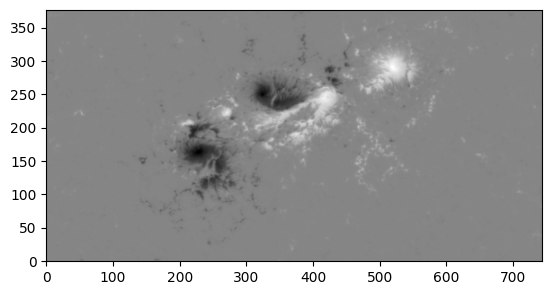

In [18]:
plt.imshow(los, origin='lower', cmap='gray')

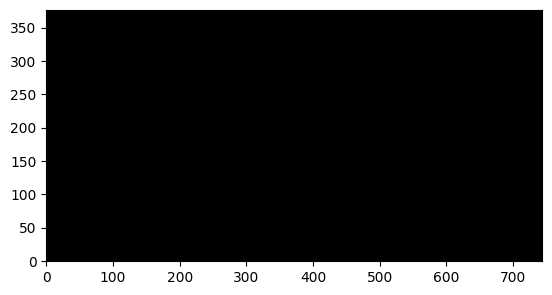

In [19]:
plt.imshow(los_err, origin='lower', cmap='gray')

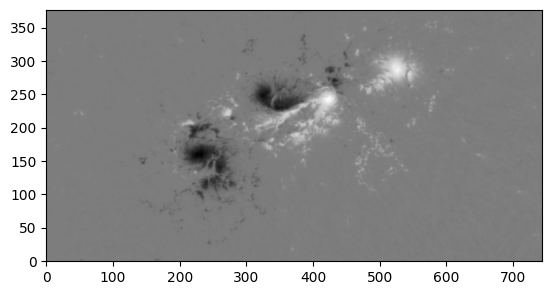

In [20]:
plt.imshow(bz, origin='lower', cmap='gray')

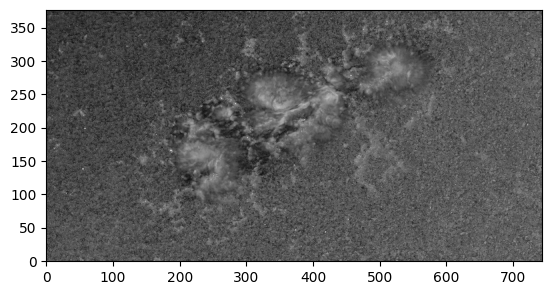

In [21]:
plt.imshow(bz_err, origin='lower', cmap='gray', norm='log')

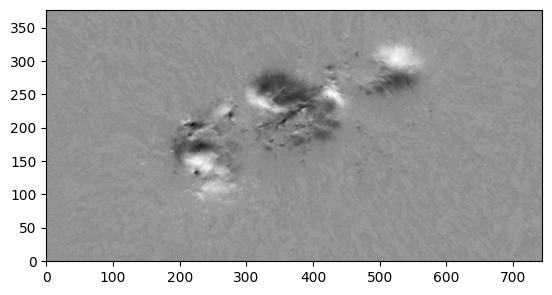

In [22]:
plt.imshow(by, origin='lower', cmap='gray')

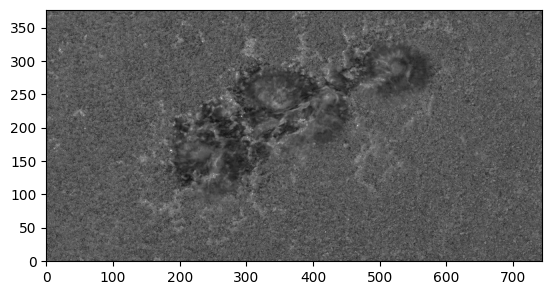

In [23]:
plt.imshow(by_err, origin='lower', cmap='gray', norm='log')

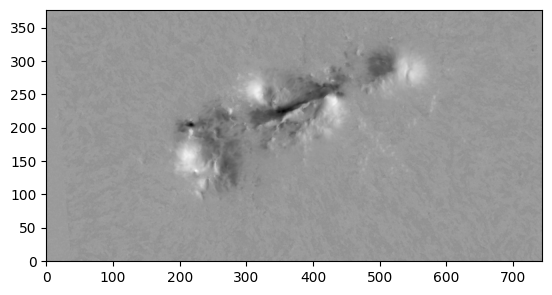

In [24]:
plt.imshow(bx, origin='lower', cmap='gray')

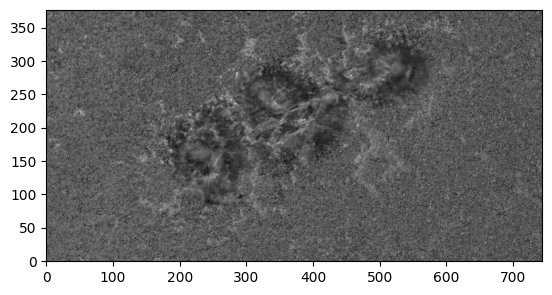

In [25]:
plt.imshow(bx_err, origin='lower', cmap='gray', norm='log')

In [26]:
np.unique(conf_disambig)

array([ 0, 60, 90], dtype=int16)

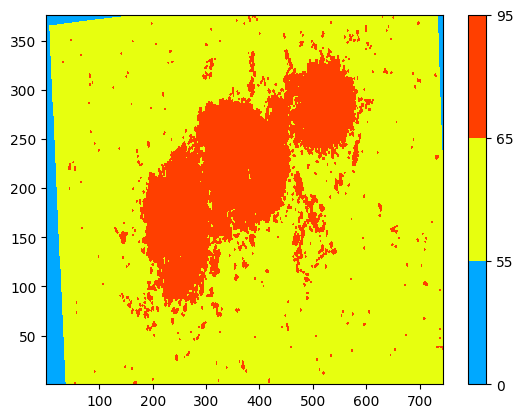

In [27]:
plt.contourf(conf_disambig, origin='lower', cmap='jet', levels=[0, 55, 65, 95])
plt.colorbar()

In [28]:
conf_disambig

array([[ 0,  0,  0, ..., 60, 60, 60],
       [ 0,  0,  0, ..., 60, 60, 60],
       [ 0,  0,  0, ..., 60, 60, 60],
       ...,
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0]], dtype=int16)

In [29]:
np.unique(bitmap)

array([ 0,  1,  2, 33, 34], dtype='>i2')

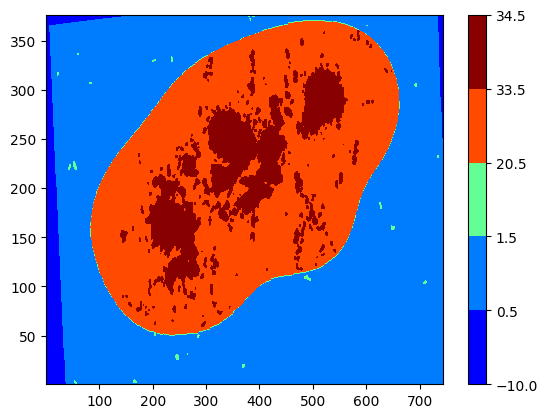

In [30]:
plt.contourf(bitmap, origin='lower', cmap='jet', levels=[-10, 0.5, 1.5, 20.5, 33.5, 34.5])
plt.colorbar()

In [31]:
bitmap

array([[0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype='>i2')

---

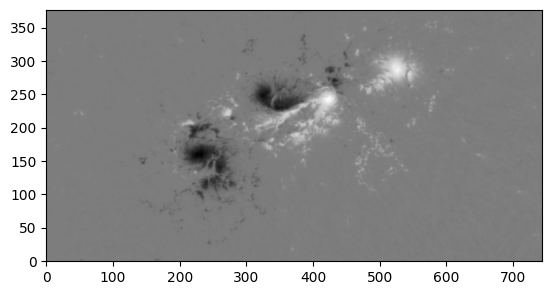

In [32]:
plt.imshow(bz, origin='lower', cmap='gray')

In [33]:
good_and_HARP = (conf_disambig >= 70) * (bitmap >= 30)
good_and_HARP.shape

(377, 744)

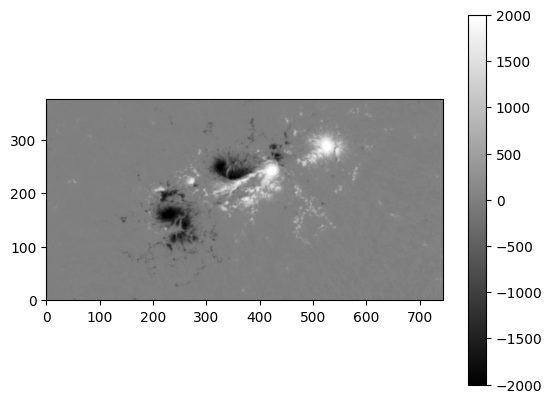

In [34]:
plt.imshow(bz, origin='lower', cmap='gray', vmin=-2000, vmax=2000)
plt.colorbar()

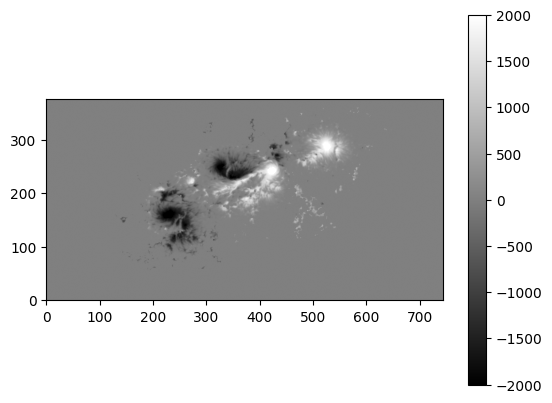

In [35]:
plt.imshow((bz * good_and_HARP), origin='lower', cmap='gray', vmin=-2000, vmax=2000)
plt.colorbar()

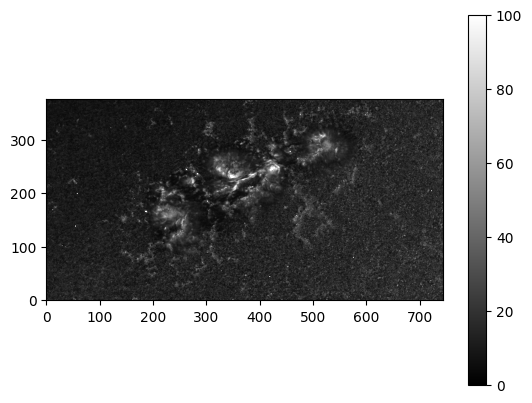

In [36]:
plt.imshow(bz_err, origin='lower', cmap='gray', vmin=0, vmax=100)
plt.colorbar()

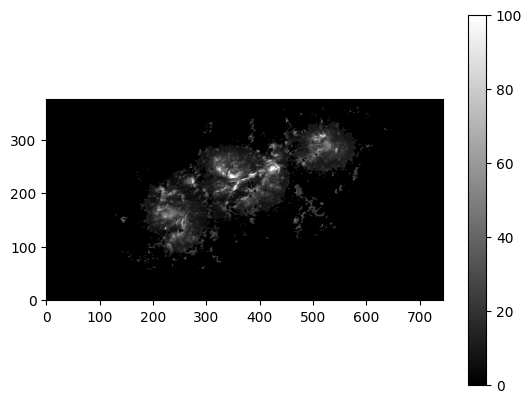

In [37]:
plt.imshow((bz_err * good_and_HARP), origin='lower', cmap='gray', vmin=0, vmax=100)
plt.colorbar()

---

1 pixel = (cdelt1_arcsec)(rsun_ref/rsun_obs) m

1 pixel = (cdelt1)(pi/180)(run_ref) m

In [38]:
cdelt1_arcsec * (rsun_ref / rsun_obs)

364423.3492075986

In [39]:
cdelt1 * (np.pi/180) * rsun_ref

364424.74781641597

---

USFLUX : Total unsigned flux [Mx]

ERRVF  : Error in USFLUX [Mx]

CMASK : Total number of pixels used in the calculation of USFLUX

In [40]:
sum = 0.0
err = 0.0
count_mask = 0

for j in range(ny):
    for i in range(nx):
        if ( conf_disambig[j, i] < 70 or bitmap[j, i] < 30 ):
            continue
        if np.isnan(bz[j, i]):
            continue
        sum += abs(bz[j, i])                # Gauss * pix^2
        err += bz_err[j, i]**2  # Gauss^2 * pix^4
        count_mask += 1

cm2_per_pix2 = ( cdelt1_arcsec*(rsun_ref/rsun_obs)*100.0 )**2

mean_vf = sum * cm2_per_pix2               # Gauss * cm^2
mean_vf_err = np.sqrt(err) * cm2_per_pix2  # Gauss * cm^2

In [41]:
print(f"USFLUX = {header['USFLUX']} Mx")
print(f"ERRVF = {header['ERRVF']} Mx")
print(f"CMASK = {header['CMASK']}")

USFLUX = 2.71476e+22 Mx
ERRVF = 6.891751e+18 Mx
CMASK = 45703.0


In [42]:
print(f"USFLUX = {mean_vf:.6g} Mx")
print(f"ERRVF = {mean_vf_err:.7g} Mx")
print(f"CMASK = {count_mask}")

USFLUX = 2.71476e+22 Mx
ERRVF = 6.891752e+18 Mx
CMASK = 45703


---

MEANGAM : Mean inclination angle [degree]

ERRGAM  : Error in MEANGAM [degree]

In [43]:
bh = np.zeros([ny, nx])
bh_err = np.zeros([ny, nx])

for j in range(ny):
    for i in range(nx):
        if ( np.isnan(bx[j, i]) or np.isnan(by[j, i]) ):
            bh[j, i] = np.nan
            bh_err[j, i] = np.nan
            continue
        bh[j, i] = np.sqrt( bx[j, i]**2 + by[j, i]**2 )
        bh_err[j, i] = np.sqrt( ((bx[j, i]*bx_err[j, i])**2 + (by[j, i]*by_err[j, i])**2))/ bh[j, i]

In [44]:
print(f"bh.shape = {bh.shape}")
print(f"bh_err.shape = {bh_err.shape}")

bh.shape = (377, 744)
bh_err.shape = (377, 744)


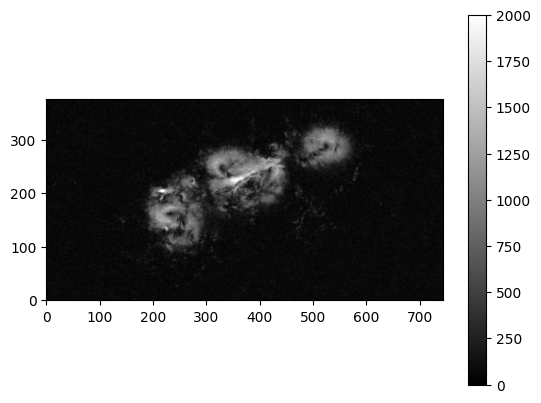

In [65]:
plt.imshow(bh, origin='lower', cmap='gray', vmin=0, vmax=2000)
plt.colorbar()

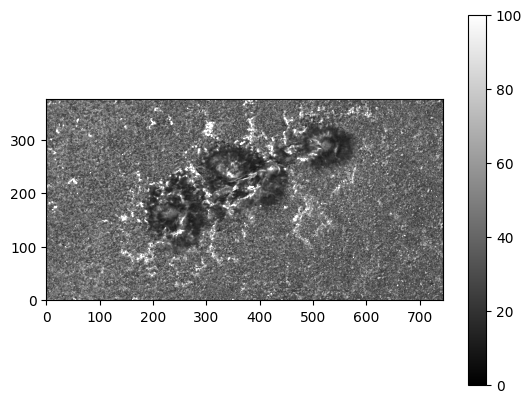

In [46]:
plt.imshow(bh_err, origin='lower', cmap='gray', vmin=0, vmax=100)
plt.colorbar()

In [47]:
sum = 0.0
err = 0.0
count_mask = 0

for j in range(ny):
    for i in range(nx):
        if ( conf_disambig[j, i] < 70 or bitmap[j, i] < 30 ):
            continue
        if ( np.isnan(bz[j,i]) or np.isnan(bz_err[j,i]) or np.isnan(bh[j,i]) or np.isnan(bh_err[j,i]) or bz[j,i] == 0 ):
            continue
        if ( bh[j,i] < 100 ):
            continue
        sum += abs(math.atan(bh[j, i]/abs(bz[j, i]))) * (180.0/np.pi)
        err += ( 1/(1 + (bh[j, i]/bz[j, i])**2) )**2 * ( bh_err[j, i]**2/bz[j, i]**2 + (bh[j, i]**2*bz_err[j, i]**2)/bz[j, i]**4 )
        count_mask += 1

mean_gamma     = sum / count_mask
mean_gamma_err = ( np.sqrt(err)/count_mask ) * (180.0/np.pi)

In [66]:
print(f"MEANGAM = {header['MEANGAM']} degree")
print(f"ERRGAM = {header['ERRGAM']} degree")

MEANGAM = 59.699 degree
ERRGAM = 0.018 degree


In [67]:
print(f"MEANGAM = {mean_gamma:.5g} degree")
print(f"ERRGAM = {mean_gamma_err:.2g} degree")

MEANGAM = 59.699 degree
ERRGAM = 0.018 degree


---

MEANGBT : Mean value of the horizontal gradient of total field [Gauss/Mm]

ERRBT  : Error in MEANGBT [Gauss/Mm]


MEANGBZ : Mean value of the horizontal gradient of vertical field [Gauss/Mm]

ERRBZ  : Error in MEANGBZ [Gauss/Mm]


MEANGBH : Mean value of the horizontal gradient of horizontal field [Gauss/Mm]

ERRBH  : Error in MEANGBH [Gauss/Mm]

In [81]:
print(f"MEANGBT = {header['MEANGBT']} G/Mm")
print(f"ERRBT = {header['ERRBT']} G/Mm")

print(f"MEANGBZ = {header['MEANGBZ']} G/Mm")
print(f"ERRBZ = {header['ERRBZ']} G/Mm")

print(f"MEANGBH = {header['MEANGBH']} G/Mm")
print(f"ERRBH = {header['ERRBH']} G/Mm")

MEANGBT = 93.508 G/Mm
ERRBT = 0.111 G/Mm
MEANGBZ = 100.523 G/Mm
ERRBZ = 0.081 G/Mm
MEANGBH = 67.188 G/Mm
ERRBH = 0.13 G/Mm


In [51]:
bt     = np.zeros([ny, nx])
bt_err = np.zeros([ny, nx])

for j in range(ny):
    for i in range(nx):
        if (np.isnan(bx[j,i]) or np.isnan(by[j,i]) or np.isnan(bz[j,i])):
            bt[j,i] = np.nan
            bt_err[j,i] = np.nan
            continue
        bt[j,i] = np.sqrt( bx[j,i]**2 + by[j,i]**2 + bz[j,i]**2 )
        bt_err[j, i] = np.sqrt( ((bx[j, i]*bx_err[j, i])**2 + (by[j, i]*by_err[j, i])**2 + (bz[j, i]*bz_err[j, i])**2) ) / bt[j, i]

In [52]:
print(f"bt.shape = {bt.shape}")
print(f"bt_err.shape = {bt_err.shape}")

bt.shape = (377, 744)
bt_err.shape = (377, 744)


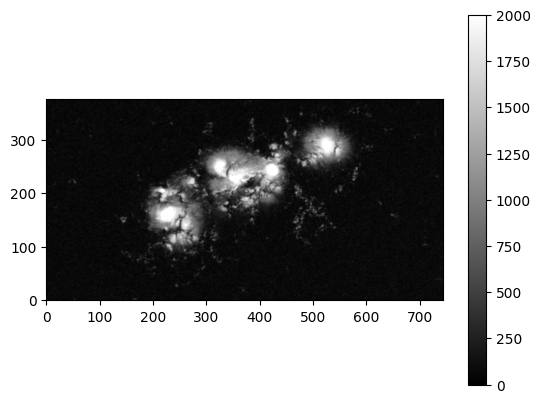

In [53]:
plt.imshow(bt, origin='lower', cmap='gray', vmin=0, vmax=2000)
plt.colorbar()

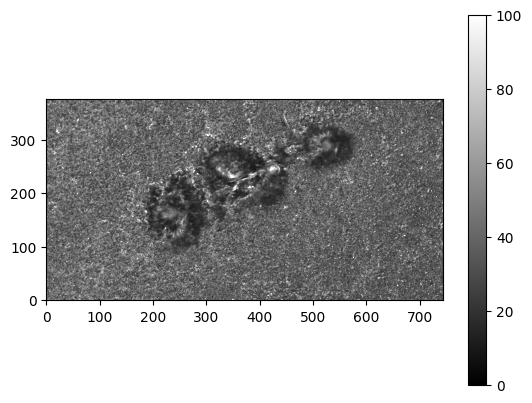

In [54]:
plt.imshow(bt_err, origin='lower', cmap='gray', vmin=0, vmax=100)
plt.colorbar()

In [63]:
count_mask = 0
sum        = 0.0
err        = 0.0

derx_bt   = np.zeros([ny,nx])
dery_bt   = np.zeros([ny,nx])
err_term1 = np.zeros([ny,nx])
err_term2 = np.zeros([ny,nx])

# brute force method of calculating the derivative d/dx (no consideration for edges)
for i in range(1,nx-1):
    for j in range(0,ny):
        derx_bt[j,i]   = (bt[j,i+1] - bt[j,i-1])*0.5
        err_term1[j,i] = (bt[j,i+1]-bt[j,i-1])**2 * (bt_err[j,i+1]**2 + bt_err[j,i-1]**2)

#brute force method of calculating the derivative d/dy (no consideration for edges)
for i in range(0,nx):
    for j in range(1,ny-1):
        dery_bt[j,i]   = (bt[j+1,i] - bt[j-1,i])*0.5
        err_term2[j,i] = (bt[j+1,i]-bt[j-1,i])**2 * (bt_err[j+1,i]**2 + bt_err[j-1,i]**2)

    
# consider the edges for the arrays that contribute to the variable "sum" in the computation below.
# ignore the edges for the error terms as those arrays have been initialized to zero. 
# this is okay because the error term will ultimately not include the edge pixels as they are selected out by the conf_disambig and bitmap arrays.


i=0
for j in range(ny):
    derx_bt[j,i] = ( (-3*bt[j,i]) + (4*bt[j,i+1]) - (bt[j,i+2]) )*0.5

i=nx-1
for j in range(ny):
    derx_bt[j,i] = ( (3*bt[j,i]) + (-4*bt[j,i-1]) - (-bt[j,i-2]) )*0.5

j=0
for i in range(nx):
    dery_bt[j,i] = ( (-3*bt[j,i]) + (4*bt[j+1,i]) - (bt[j+2,i]) )*0.5

j=ny-1
for i in range(nx):
    dery_bt[j,i] = ( (3*bt[j,i]) + (-4*bt[j-1,i]) - (-bt[j-2,i]) )*0.5


# Calculate the sum only
for j in range(1,ny-1):
    for i in range (1,nx-1):
        if ( conf_disambig[j,i] < 70 or bitmap[j,i] < 30 ):
            continue
        if ( (derx_bt[j,i] + dery_bt[j,i]) == 0):
            continue
        if np.isnan(bt[j,i]):
            continue
        if np.isnan(bt[j+1,i]):
            continue
        if np.isnan(bt[j-1,i]):
            continue
        if np.isnan(bt[j,i-1]):
            continue
        if np.isnan(bt[j,i+1]):
            continue
        if np.isnan(bt_err[j,i]):
            continue
        if np.isnan(derx_bt[j,i]):
            continue
        if np.isnan(dery_bt[j,i]):
            continue
        sum += np.sqrt( derx_bt[j,i]**2  + dery_bt[j,i]**2  )
        err += err_term2[j,i] / (16.0*( derx_bt[j,i]**2  + dery_bt[j,i]**2 )) + err_term1[j,i] / (16.0*( derx_bt[j,i]**2  + dery_bt[j,i]**2 ))
        count_mask += 1

mean_derivative_bt     = (sum)/(count_mask)
mean_derivative_bt_err = (np.sqrt(err))/(count_mask)

In [82]:
print(f"MEANGBT = {header['MEANGBT']} G/Mm")
print(f"ERRBT = {header['ERRBT']} G/Mm")
print()
print(f"MEANGBT = {mean_derivative_bt:.5g} G/Mm")
print(f"ERRBT = {mean_derivative_bt_err:.3g} G/Mm")

MEANGBT = 93.508 G/Mm
ERRBT = 0.111 G/Mm

MEANGBT = 93.508 G/Mm
ERRBT = 0.111 G/Mm


In [73]:
count_mask = 0
sum        = 0.0
err        = 0.0

derx_bz   = np.zeros([ny,nx])
dery_bz   = np.zeros([ny,nx])
err_term1 = np.zeros([ny,nx])
err_term2 = np.zeros([ny,nx])

# brute force method of calculating the derivative d/dx (no consideration for edges)
for i in range(1,nx-1):
    for j in range(0,ny):
        derx_bz[j,i]   = (bz[j,i+1] - bz[j,i-1])*0.5
        err_term1[j,i] = (bz[j,i+1]-bz[j,i-1])**2 * (bz_err[j,i+1]**2 + bz_err[j,i-1]**2)

#brute force method of calculating the derivative d/dy (no consideration for edges)
for i in range(0,nx):
    for j in range(1,ny-1):
        dery_bz[j,i]   = (bz[j+1,i] - bz[j-1,i])*0.5
        err_term2[j,i] = (bz[j+1,i]-bz[j-1,i])**2 * (bz_err[j+1,i]**2 + bz_err[j-1,i]**2)

    
# consider the edges for the arrays that contribute to the variable "sum" in the computation below.
# ignore the edges for the error terms as those arrays have been initialized to zero. 
# this is okay because the error term will ultimately not include the edge pixels as they are selected out by the conf_disambig and bitmap arrays.


i=0
for j in range(ny):
    derx_bz[j,i] = ( (-3*bz[j,i]) + (4*bz[j,i+1]) - (bz[j,i+2]) )*0.5

i=nx-1
for j in range(ny):
    derx_bz[j,i] = ( (3*bz[j,i]) + (-4*bz[j,i-1]) - (-bz[j,i-2]) )*0.5

j=0
for i in range(nx):
    dery_bz[j,i] = ( (-3*bz[j,i]) + (4*bz[j+1,i]) - (bz[j+2,i]) )*0.5

j=ny-1
for i in range(nx):
    dery_bz[j,i] = ( (3*bz[j,i]) + (-4*bz[j-1,i]) - (-bz[j-2,i]) )*0.5


# Calculate the sum only
for j in range(1,ny-1):
    for i in range (1,nx-1):
        if ( conf_disambig[j,i] < 70 or bitmap[j,i] < 30 ):
            continue
        if ( (derx_bz[j,i] + dery_bz[j,i]) == 0):
            continue
        if np.isnan(bz[j,i]):
            continue
        if np.isnan(bz[j+1,i]):
            continue
        if np.isnan(bz[j-1,i]):
            continue
        if np.isnan(bz[j,i-1]):
            continue
        if np.isnan(bz[j,i+1]):
            continue
        if np.isnan(bz_err[j,i]):
            continue
        if np.isnan(derx_bz[j,i]):
            continue
        if np.isnan(dery_bz[j,i]):
            continue
        sum += np.sqrt( derx_bz[j,i]**2  + dery_bz[j,i]**2  )
        err += err_term2[j,i] / (16.0*( derx_bz[j,i]**2  + dery_bz[j,i]**2 )) + err_term1[j,i] / (16.0*( derx_bz[j,i]**2  + dery_bz[j,i]**2 ))
        count_mask += 1

mean_derivative_bz     = (sum)/(count_mask)
mean_derivative_bz_err = (np.sqrt(err))/(count_mask)

In [83]:
print(f"MEANGBZ = {header['MEANGBZ']} G/Mm")
print(f"ERRBZ = {header['ERRBZ']} G/Mm")
print()
print(f"MEANGBZ = {mean_derivative_bz:.6g} G/Mm")
print(f"ERRBZ = {mean_derivative_bz_err:.2g} G/Mm")

MEANGBZ = 100.523 G/Mm
ERRBZ = 0.081 G/Mm

MEANGBZ = 100.521 G/Mm
ERRBZ = 0.081 G/Mm


In [70]:
count_mask = 0
sum        = 0.0
err        = 0.0

derx_bh   = np.zeros([ny,nx])
dery_bh   = np.zeros([ny,nx])
err_term1 = np.zeros([ny,nx])
err_term2 = np.zeros([ny,nx])

# brute force method of calculating the derivative d/dx (no consideration for edges)
for i in range(1,nx-1):
    for j in range(0,ny):
        derx_bh[j,i]   = (bh[j,i+1] - bh[j,i-1])*0.5
        err_term1[j,i] = (bh[j,i+1]-bh[j,i-1])**2 * (bh_err[j,i+1]**2 + bh_err[j,i-1]**2)

#brute force method of calculating the derivative d/dy (no consideration for edges)
for i in range(0,nx):
    for j in range(1,ny-1):
        dery_bh[j,i]   = (bh[j+1,i] - bh[j-1,i])*0.5
        err_term2[j,i] = (bh[j+1,i]-bh[j-1,i])**2 * (bh_err[j+1,i]**2 + bh_err[j-1,i]**2)

    
# consider the edges for the arrays that contribute to the variable "sum" in the computation below.
# ignore the edges for the error terms as those arrays have been initialized to zero. 
# this is okay because the error term will ultimately not include the edge pixels as they are selected out by the conf_disambig and bitmap arrays.


i=0
for j in range(ny):
    derx_bh[j,i] = ( (-3*bh[j,i]) + (4*bh[j,i+1]) - (bh[j,i+2]) )*0.5

i=nx-1
for j in range(ny):
    derx_bh[j,i] = ( (3*bh[j,i]) + (-4*bh[j,i-1]) - (-bh[j,i-2]) )*0.5

j=0
for i in range(nx):
    dery_bh[j,i] = ( (-3*bh[j,i]) + (4*bh[j+1,i]) - (bh[j+2,i]) )*0.5

j=ny-1
for i in range(nx):
    dery_bh[j,i] = ( (3*bh[j,i]) + (-4*bh[j-1,i]) - (-bh[j-2,i]) )*0.5


# Calculate the sum only
for j in range(1,ny-1):
    for i in range (1,nx-1):
        if ( conf_disambig[j,i] < 70 or bitmap[j,i] < 30 ):
            continue
        if ( (derx_bh[j,i] + dery_bh[j,i]) == 0):
            continue
        if np.isnan(bh[j,i]):
            continue
        if np.isnan(bh[j+1,i]):
            continue
        if np.isnan(bh[j-1,i]):
            continue
        if np.isnan(bh[j,i-1]):
            continue
        if np.isnan(bh[j,i+1]):
            continue
        if np.isnan(bh_err[j,i]):
            continue
        if np.isnan(derx_bh[j,i]):
            continue
        if np.isnan(dery_bh[j,i]):
            continue
        sum += np.sqrt( derx_bh[j,i]**2  + dery_bh[j,i]**2  )
        err += err_term2[j,i] / (16.0*( derx_bh[j,i]**2  + dery_bh[j,i]**2 )) + err_term1[j,i] / (16.0*( derx_bh[j,i]**2  + dery_bh[j,i]**2 ))
        count_mask += 1

mean_derivative_bh     = (sum)/(count_mask)
mean_derivative_bh_err = (np.sqrt(err))/(count_mask)

In [84]:
print(f"MEANGBH = {header['MEANGBH']} G/Mm")
print(f"ERRBH = {header['ERRBH']} G/Mm")
print()
print(f"MEANGBH = {mean_derivative_bh:.5g} G/Mm")
print(f"ERRBH = {mean_derivative_bh_err:.2g} G/Mm")

MEANGBH = 67.188 G/Mm
ERRBH = 0.13 G/Mm

MEANGBH = 67.188 G/Mm
ERRBH = 0.13 G/Mm


---

MEANJZD : Mean vertical current density [mA * m^(-2)]

ERRJZ : Error in MEANJZD [mA * m^(-2)]


TOTUSJZ : Total unsigned vertical current [A]

ERRUSI : Error in TOTUSJZ [A]

In [86]:
print(f"MEANJZD = {header['MEANJZD']} mA * m^(-2)")
print(f"ERRJZ = {header['ERRJZ']} mA * m^(-2)")

print(f"TOTUSJZ = {header['TOTUSJZ']} A")
print(f"ERRUSI = {header['ERRUSI']} A")

MEANJZD = 0.26992074 mA * m^(-2)
ERRJZ = 0.03866154 mA * m^(-2)
TOTUSJZ = 62874230000000.0 A
ERRUSI = 234658400000.0 A
